In [1]:
from pmdarima import auto_arima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm

In [3]:
auto_analysis_df = pd.read_excel(r'analysis.xlsx')

In [4]:
auto_analysis_df = auto_analysis_df[['Дата'
                                     , 'Количество выданных автокредитов в месяц, тыс. штук'
                                     , 'Число регистраций в месяц, тыс. штук'
                                     , 'Количество выданных автокредитов в месяц на новые автомобили, тыс. штук'
                                     , 'Число регистраций новых автомобилей в месяц, тыс. штук'
                                     , 'Количество выданных автокредитов в месяц на автомобили с пробегом, тыс. штук'
                                     , 'Число регистраций автомобилей с пробегом в месяц, тыс. штук'
                                     , 'Ключ ЦБ РФ'
                                    ]]

In [5]:
auto_analysis_df.rename(columns={'Дата': 'report_date'
                                 , 'Количество выданных автокредитов в месяц, тыс. штук' : 'auto_loan_k'
                                 , 'Число регистраций в месяц, тыс. штук' : 'auto_register_k'
                                 , 'Количество выданных автокредитов в месяц на новые автомобили, тыс. штук' : 'new_auto_loan_k'
                                 , 'Число регистраций новых автомобилей в месяц, тыс. штук' : 'new_auto_register_k'
                                 , 'Количество выданных автокредитов в месяц на автомобили с пробегом, тыс. штук' : 'old_auto_loan_k'
                                 , 'Число регистраций автомобилей с пробегом в месяц, тыс. штук' : 'old_auto_register_k'
                                 ,  'Ключ ЦБ РФ' : 'cbr_key_rate'
                                }, inplace=True)

In [6]:
auto_analysis_df = auto_analysis_df[auto_analysis_df.report_date<'2025-01-31']

In [7]:
auto_analysis_df = auto_analysis_df.set_index('report_date')

In [8]:
x_df = auto_analysis_df['auto_loan_k']
y_df = auto_analysis_df['auto_register_k']
x_name = 'Количество выданных автокредитов в месяц, тыс. штук'
y_name = 'Число регистраций в месяц, тыс. штук'



# x_df = auto_analysis_df['new_auto_loan_k']
# y_df = auto_analysis_df['new_auto_register_k']
# x_name = 'Количество выданных автокредитов в месяц на новые автомобили, тыс. штук'
# y_name = 'Число регистраций новых автомобилей в месяц, тыс. штук'



# x_df = auto_analysis_df['old_auto_loan_k']
# y_df = auto_analysis_df['old_auto_register_k']
# x_name = 'Количество выданных автокредитов в месяц на автомобили с пробегом, тыс. штук'
# y_name = 'Число регистраций автомобилей с пробегом в месяц, тыс. штук'

In [9]:
key_rate = 21

In [10]:
# define model
model = SARIMAX(x_df
                , exog = auto_analysis_df['cbr_key_rate']
                , order=(0, 1, 1)
                , seasonal_order=(0, 1, 1, 12)
               )

C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [11]:
model_fit = model.fit()

C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [12]:
#summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        auto_loan_k   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -158.377
Date:                            Fri, 07 Mar 2025   AIC                            324.754
Time:                                    19:30:25   BIC                            330.975
Sample:                                01-31-2021   HQIC                           326.901
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cbr_key_rate    -1.1015      2.303     -0.478      0.632      -5.614       3.411
ma.L1           -0.1466      0.198     -0.739      0.460      -0.536       0.242
ma.S.L12        -0.9972     90.236     -0.011      0.991    -177.856     175.861
sigma2         313.4105   2.82e+04      0.011      0.991    -5.5e+04    5.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.42
Prob(Q):                              0.93   Prob(JB):                         0.02
Heteroskedasticity (H):               1.74   Skew:                            -0.67
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Forecast the next 12 steps
forecast_steps = 12

future_exog = np.ones(12)*key_rate

forecast = model_fit.get_forecast(steps=forecast_steps
                                  , exog=future_exog.reshape(-1, 1)
                                 )
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecast
# forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast_mean).rename(columns={'predicted_mean': 'Forecast'})

# Combine the original data and the forecast
combined_df = pd.concat([x_df, forecast_df], axis=0)

# Display the forecast
# print(forecast_df)

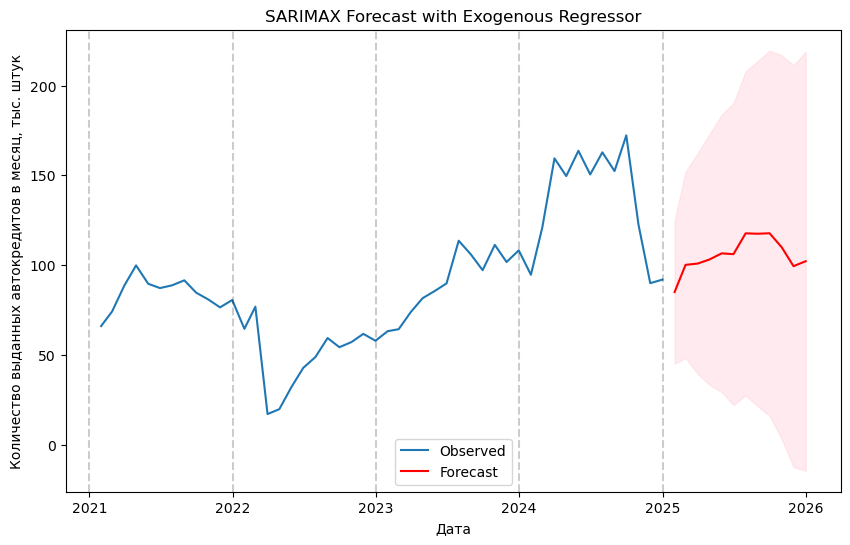

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df[x_df.name], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast with Exogenous Regressor')
plt.xlabel('Дата')
plt.ylabel(x_name)
plt.legend()
for year in range(x_df.index.year.min(),x_df.index.year.max()+2):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

In [15]:
# Define the model
model = SARIMAX(y_df
                ,  exog = pd.concat([x_df, auto_analysis_df['cbr_key_rate']], axis=1)
                , order=(12, 1, 0)
                , seasonal_order=(0, 1, 1, 12)
)

# Fit the model
results = model.fit(disp=False)

# Display the summary of the model
results.summary()

C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                       auto_register_k   No. Observations:                   48
Model:             SARIMAX(12, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -183.414
Date:                               Fri, 07 Mar 2025   AIC                            398.829
Time:                                       19:30:26   BIC                            423.714
Sample:                                   01-31-2021   HQIC                           407.419
                                        - 12-31-2024                                         
Covariance Type:                                 opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
auto_loan_k      1.5140      0.462      3.278      0.001       0.609       2.419
cbr_key_rate     7.0570      3.241      2.177      0.029       0.705      13.409
ar.L1           -0.3531      0.392     -0.902      0.367      -1.120       0.414
ar.L2            0.2671      0.358      0.745      0.456      -0.435       0.969
ar.L3            0.1019      0.353      0.289      0.773      -0.590       0.794
ar.L4           -0.2610      0.496     -0.526      0.599      -1.233       0.711
ar.L5           -0.2740      0.372     -0.736      0.462      -1.003       0.456
ar.L6            0.2775      0.410      0.677      0.498      -0.526       1.081
ar.L7           -0.2602      0.256     -1.017      0.309      -0.762       0.241
ar.L8           -0.0864      0.511     -0.169      0.866      -1.089       0.916
ar.L9            0.1369      0.267      0.512      0.608      -0.387       0.660
ar.L10          -0.1800      0.483     -0.373      0.709      -1.126       0.766
ar.L11          -0.2830      0.378     -0.748      0.455      -1.025       0.459
ar.L12          -0.2611      0.422     -0.619      0.536      -1.087       0.565
ma.S.L12        -0.8435      3.551     -0.238      0.812      -7.804       6.117
sigma2        1188.6350   4081.284      0.291      0.771   -6810.535    9187.805
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.50   Prob(JB):                         0.44
Heteroskedasticity (H):               1.06   Skew:                            -0.42
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Forecast the next 12 steps
forecast_steps = 12

# Create future values for the exogenous variable
future_exog_1 = combined_df[-12:]['Forecast'].values  # Simulate future exogenous values
future_exog_2 = np.ones(12)*key_rate
future_exog = np.column_stack((future_exog_1, future_exog_2))

# Forecast
forecast = results.get_forecast(steps=forecast_steps
                                , exog=future_exog
                               )
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecast
# forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast_mean).rename(columns={'predicted_mean': 'Forecast'})

# Combine the original data and the forecast
combined_df = pd.concat([y_df, forecast_df], axis=0)

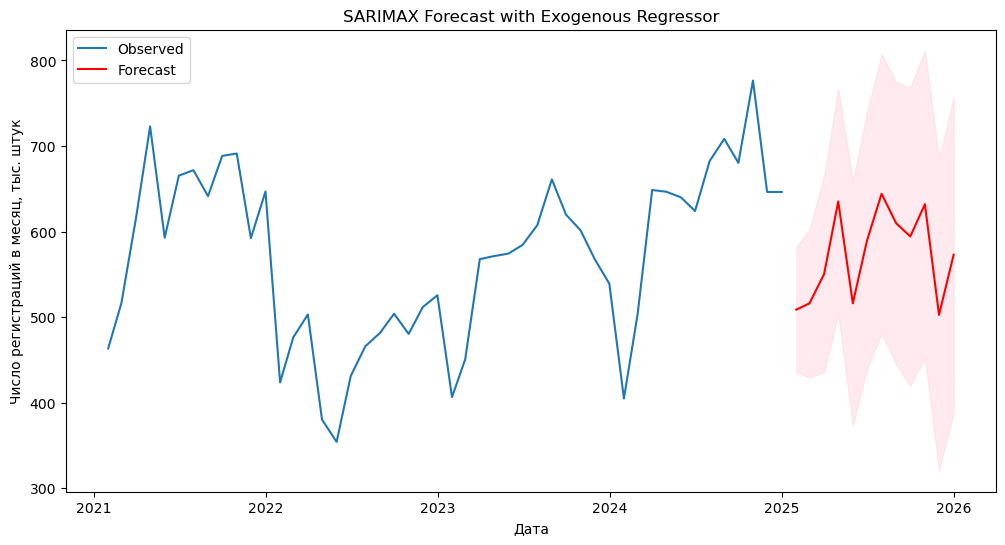

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df[y_df.name], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast with Exogenous Regressor')
plt.xlabel('Дата')
plt.ylabel(y_name)
plt.legend()
plt.show()

In [ ]:
forecast_ci.to_excel(r"forecast_ci.xlsx", index=True)

In [ ]:
combined_df.to_excel(r"combined_df.xlsx", index=True)